In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [4]:
#INPUT_DIRECTORY='/content/drive/MyDrive/training'

In [5]:
#!unzip '/content/drive/MyDrive/training.zip'

Archive:  /content/drive/MyDrive/training.zip
   creating: training/.ipynb_checkpoints/
  inflating: training/.ipynb_checkpoints/training-checkpoint.ipynb  
   creating: training/PlantVillage/
   creating: training/PlantVillage/Potato___Early_blight/
  inflating: training/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: training/PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: training/PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: training/PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: training/PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: training/PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: training/PlantVillage/Potato

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/PlantVillage",
seed=123,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 2140 files belonging to 3 classes.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0])
    print(labels_batch.numpy())

tf.Tensor(
[[[165. 156. 161.]
  [163. 154. 159.]
  [163. 154. 159.]
  ...
  [157. 151. 161.]
  [159. 153. 163.]
  [161. 155. 165.]]

 [[165. 156. 161.]
  [162. 153. 158.]
  [161. 152. 157.]
  ...
  [157. 151. 161.]
  [159. 153. 163.]
  [160. 154. 164.]]

 [[164. 155. 160.]
  [159. 150. 155.]
  [158. 149. 154.]
  ...
  [165. 159. 169.]
  [165. 159. 169.]
  [166. 160. 170.]]

 ...

 [[113. 100. 107.]
  [114. 101. 108.]
  [110.  97. 104.]
  ...
  [110.  98. 108.]
  [110.  98. 108.]
  [110.  98. 108.]]

 [[114. 101. 108.]
  [111.  98. 105.]
  [105.  92.  99.]
  ...
  [110.  98. 108.]
  [108.  96. 106.]
  [106.  94. 104.]]

 [[111.  98. 105.]
  [110.  97. 104.]
  [107.  94. 101.]
  ...
  [113. 101. 111.]
  [109.  97. 107.]
  [106.  94. 104.]]], shape=(256, 256, 3), dtype=float32)
[1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 2 1 1 1 0 0 0 0 1 0 0 1]


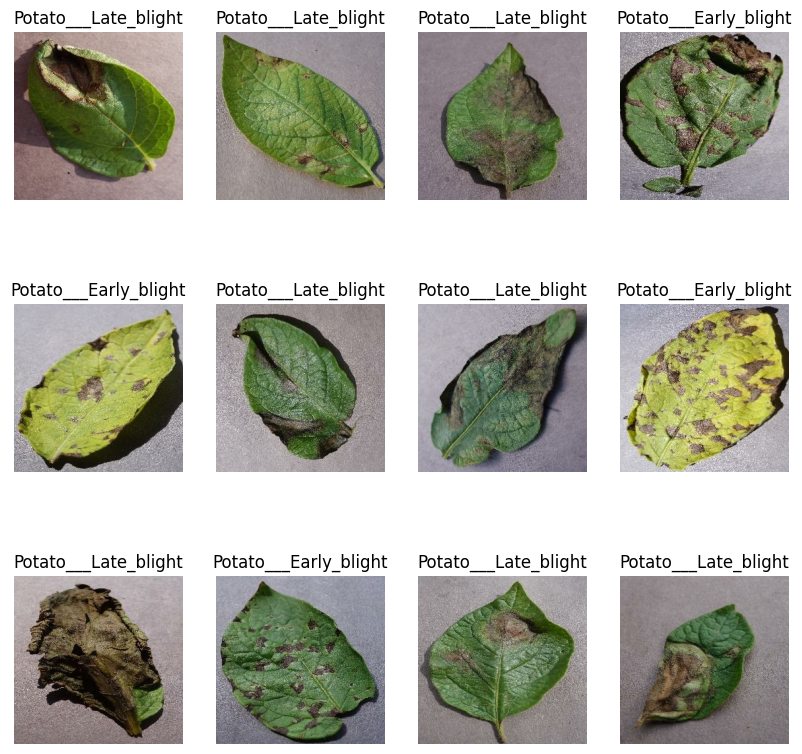

In [11]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

67

In [13]:
train_size=0.8
len(dataset)*train_size

53.6

In [14]:
train_ds=dataset.take(54)
len(train_ds)

54

In [15]:
test_ds=dataset.skip(54)
len(test_ds)

13

In [16]:
val_size=0.1
len(dataset)*val_size

6.7

In [17]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds=test_ds.skip(6)
len(test_ds)

7

In [19]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+val_split+test_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

53

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),

])

In [26]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),


])

In [29]:
model.build(input_shape=input_shape)


In [30]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
history=model.fit(train_ds,
                  batch_size=BATCH_SIZE,
                  validation_data=val_ds,
                  verbose=1,
                  epochs=50,)

Epoch 1/50
53/53 [==============================] - 446s 5s/step - loss: 0.9263 - accuracy: 0.4764 - val_loss: 0.9473 - val_accuracy: 0.6615
Epoch 2/50
53/53 [==============================] - 259s 5s/step - loss: 0.8232 - accuracy: 0.6040 - val_loss: 0.8001 - val_accuracy: 0.5521
Epoch 3/50
53/53 [==============================] - 255s 5s/step - loss: 0.5811 - accuracy: 0.7246 - val_loss: 0.4976 - val_accuracy: 0.7604
Epoch 4/50
53/53 [==============================] - 251s 5s/step - loss: 0.3773 - accuracy: 0.8369 - val_loss: 0.3740 - val_accuracy: 0.8385
Epoch 5/50
53/53 [==============================] - 253s 5s/step - loss: 0.2809 - accuracy: 0.8895 - val_loss: 0.3468 - val_accuracy: 0.8542
Epoch 6/50
53/53 [==============================] - 243s 5s/step - loss: 0.2601 - accuracy: 0.8948 - val_loss: 0.3215 - val_accuracy: 0.8854
Epoch 7/50
53/53 [==============================] - 237s 4s/step - loss: 0.2107 - accuracy: 0.9108 - val_loss: 0.2393 - val_accuracy: 0.9115
Epoch 8/50
53

In [33]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 16s 1s/step - loss: 0.0726 - accuracy: 0.9688


In [34]:
print(scores)

[0.0726105123758316, 0.96875]


In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

first image to predict
actual label Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


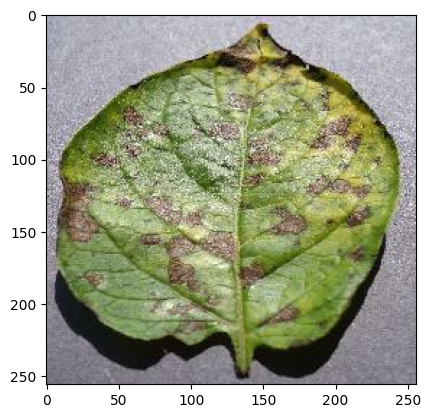

In [36]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])




In [37]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 89ms/step


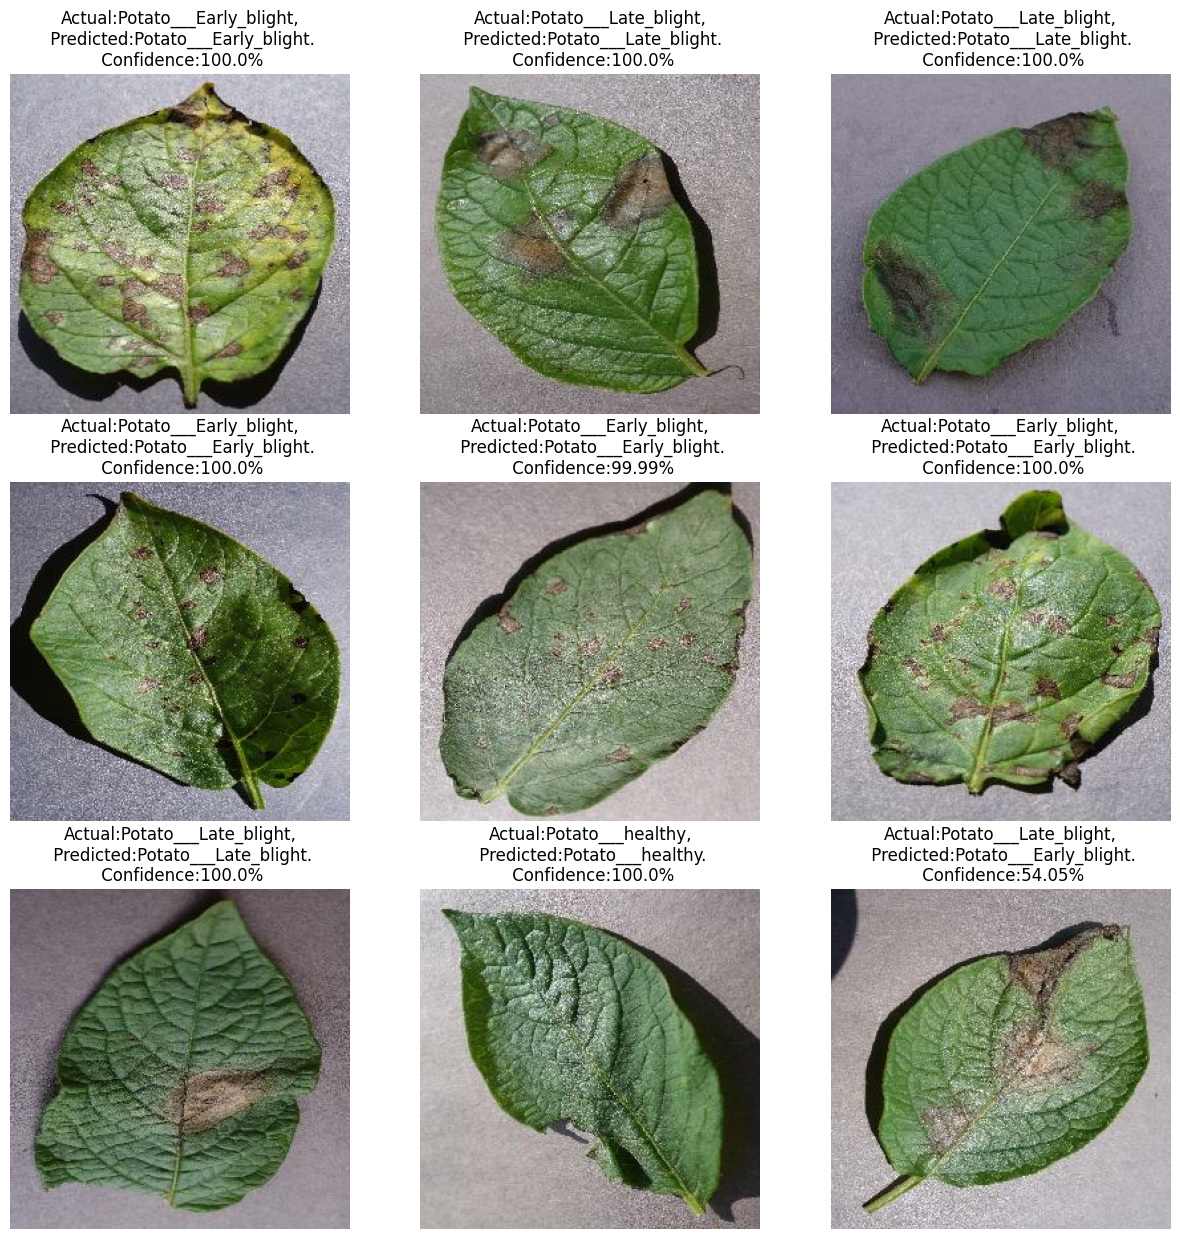

In [38]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
    plt.axis("off")

In [40]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: ignored